In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
from scipy.stats import norm, dirichlet, invgamma, truncnorm, beta, gamma
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from scipy.stats import probplot
import copy

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
#read in the raw data and immediately remove non balls in play to save memory. Only go back to 2020 to save time when training models
from google.colab import drive
drive.mount('/drive')

raw23 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw23.csv')
raw23 = raw23.loc[raw23['type'] == 'X']

raw22= pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw22.csv')
raw22 = raw22.loc[raw22['type'] == 'X']

raw21 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw21.csv')
raw21 = raw21.loc[raw21['type'] == 'X']

raw20 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw20.csv')
raw20 = raw20.loc[raw20['type'] == 'X']


Mounted at /drive


In [4]:
#combine
all_data = pd.concat((raw23, raw22, raw21, raw20))

del raw22
del raw21
del raw20
del raw23

#we only want balls in play with non-null measurements
all_data = all_data.loc[all_data['type'] == 'X']
all_data = all_data.dropna(subset = ['hc_x', 'hc_y', 'launch_speed', 'launch_angle', 'hit_distance_sc', 'release_speed', 'release_spin_rate', 'plate_x', 'plate_z', 'pfx_x', 'pfx_z'])

#one hot encode handedness
pit_hand = pd.get_dummies(all_data['p_throws'], drop_first = False, dtype = int)
bat_hand = pd.get_dummies(all_data['stand'], drop_first = False, dtype = int)
all_data['pit_handR'] = pit_hand['R']
all_data['bat_handR'] = bat_hand['R']

pit_hand = pd.get_dummies(all_data['p_throws'], drop_first = False)
bat_hand = pd.get_dummies(all_data['stand'], drop_first = False)
all_data['pit_handR_bool'] = pit_hand['R']
all_data['bat_handR_bool'] = bat_hand['R']

#hit direction
all_data['x'] = all_data.hc_x.values - 125.42
all_data['y'] = 198.27 - all_data.hc_y.values
all_data['hit_direction'] = np.arctan2(all_data.x.values, all_data.y.values) * 180/np.pi
#scale hit direction by -1 for lefties so we can consider all hitters at the same time
all_data.loc[all_data.bat_handR == 0, 'hit_direction'] *= -1

#remove extreme angles.
all_data = all_data.loc[np.abs(all_data.hit_direction) < 55]

#shift and scale so that hit directions are between 0 and 1
all_data['hd'] = (all_data.hit_direction.values + 55) / 110

#define hit direction type
all_data['is_oppo'] = 0
all_data.loc[all_data.hit_direction > 0, 'is_oppo'] = 1
all_data['is_pull'] = 1-all_data.is_oppo.values

#launch angle type
all_data['la_type'] = 0 #gb
all_data.loc[(all_data.launch_angle > 10) & (all_data.launch_angle <= 25), 'la_type'] = 1 #ld
all_data.loc[(all_data.launch_angle > 25) & (all_data.launch_angle <= 50), 'la_type'] = 2 #fb
all_data.loc[all_data.launch_angle > 50, 'la_type'] = 3 #pu
all_data['is_gb'] = 0
all_data['is_ld'] = 0
all_data['is_fb'] = 0
all_data['is_pu'] = 0
all_data.loc[all_data.la_type == 0, 'is_gb'] = 1
all_data.loc[all_data.la_type == 1, 'is_ld'] = 1
all_data.loc[all_data.la_type == 2, 'is_fb'] = 1
all_data.loc[all_data.la_type == 3, 'is_pu'] = 1

#define an upper limit on exit speed and flip it around so we can use the gamma distribution
all_data['ev2'] = all_data.launch_speed.max()+0.1 - all_data.launch_speed.values

#batterid/hand
all_data['batter_id_hand'] = all_data.batter.astype(str) + '-' + all_data.bat_handR.astype(str)
all_data['batter_id_hand_bool'] = all_data.batter.astype(str) + '-' + all_data.bat_handR_bool.astype(str)

#keep only the necessary columns
all_data = all_data[['pitch_type', 'game_date', 'batter', 'sz_top', 'sz_bot', 'batter_id_hand', 'batter_id_hand_bool', 'home_team', 'away_team',
                     'balls', 'strikes', 'game_year', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up',
                     'inning', 'release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z',
                     'release_spin_rate', 'release_extension', 'pitcher',  'launch_speed', 'launch_angle', 'if_fielding_alignment', 'of_fielding_alignment', 'pit_handR',
                     'bat_handR','pit_handR_bool', 'bat_handR_bool',  'x', 'y', 'hit_direction', 'hd', 'ev2', 'is_pull', 'is_oppo', 'la_type', 'is_gb', 'is_ld', 'is_fb', 'is_pu']]

#batter indices: we need indices for the batter and handedness so that we handle switch hitters appropriately
batter_indices = pd.DataFrame({'batter_id_hand':np.sort(all_data.batter_id_hand.unique())})

batter_indices['batter_index'] = batter_indices.index.values

all_data = all_data.merge(batter_indices, on = 'batter_id_hand')

### Model

In [5]:
#convert movement from feet to inches
all_data[['mx', 'mz']] = all_data[['pfx_x', 'pfx_z']].values * 12

#standardize these pitch variables
features = ['release_speed', 'mx', 'mz', 'plate_x', 'plate_z', 'hit_direction', 'launch_angle', 'pit_handR', 'bat_handR', 'batter_index']
standardizer = StandardScaler().fit(all_data[['release_speed', 'mx', 'mz', 'plate_x', 'plate_z', 'hit_direction', 'launch_angle']].values)
all_data[['plate_x_ft', 'plate_z_ft']] = all_data[['plate_x', 'plate_z']].values
all_data[['release_speed', 'mx', 'mz', 'plate_x', 'plate_z', 'hit_direction', 'launch_angle']] = standardizer.transform(all_data[['release_speed', 'mx', 'mz', 'plate_x', 'plate_z', 'hit_direction', 'launch_angle']].values)

In [6]:
#train test split
train = all_data.loc[all_data.game_year < 2023]
test = all_data.loc[all_data.game_year == 2023]

In [7]:
#data set class
class DataSet(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype = torch.float32)
        self.y = torch.tensor(y, dtype = torch.float32)
        self.length = self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.length

train_x = train[features].values
train_y = train.ev2.values
test_x = test[features].values
test_y = test.ev2.values
trainset = DataSet(train_x, train_y)
testset = DataSet(test_x, test_y)

#data loaders
trainloader = DataLoader(trainset, batch_size =256, shuffle = True)
testloader = DataLoader(testset, batch_size = 256, shuffle = True)

In [8]:
embedding_size = 15

class EV(nn.Module):
    def __init__(self):
        super(EV, self).__init__()

        self.batter_embedding = nn.Embedding(num_embeddings = batter_indices.shape[0], embedding_dim = embedding_size)
        self.batter_embedding.weight.data.fill_(.1)
        self.al1 = nn.Linear(in_features = embedding_size + len(features) - 1, out_features = 128)
        self.al3 = nn.Linear(128, 64)
        self.al4 = nn.Linear(64, 32)

        self.bl1 = nn.Linear(in_features = embedding_size + len(features) - 1, out_features = 128)
        self.bl3 = nn.Linear(128, 64)
        self.bl4 = nn.Linear(64, 32)

        self.relu = nn.ReLU()
        self.alpha_layer1 = nn.Linear(32,1)
        self.beta_layer1 = nn.Linear(32,1)

    def forward(self, x):
        batter_idx = x[:,-1].int()
        bat_emb = self.batter_embedding(batter_idx)

        conc = torch.cat((x[:,:-1], bat_emb), dim = -1).clone()
        o = self.relu(self.al1(conc))
        o = self.relu(self.al3(o))
        o = self.relu(self.al4(o))
        alpha = nn.ELU()(self.alpha_layer1(o)) + 1.

        v = self.relu(self.bl1(conc))
        v = self.relu(self.bl3(v))
        v = self.relu(self.bl4(v))
        beta = nn.ELU()(self.beta_layer1(v)) + 1.

        return alpha, beta

In [9]:
#gamma loss
def gamma_loss(alpha, beta, target):
    dist = torch.distributions.gamma.Gamma(concentration = alpha.squeeze(1), rate = beta.squeeze(1))

    _like = dist.log_prob(target)
    return -1*_like.mean()

In [10]:
learning_rate = 5e-4
epochs = 25
model = EV().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)
loss_fn = gamma_loss
train_losses = []
test_losses = []

In [11]:
#training: loops
for i in range(epochs):
    #loop through batches of training data
    loss_val = 0
    for batch, (x, y_truth) in enumerate(trainloader):
        x = x.to(device)
        y_truth = y_truth.to(device)
        #zero out gradients
        optimizer.zero_grad()
        #run the model
        alpha, beta = model(x)
        #calculate loss
        loss = loss_fn(alpha, beta, y_truth)
        loss_val += loss.item()

        #backprop
        loss.backward()
        optimizer.step()


    train_losses.append(loss_val / len(trainloader))

    loss_val = 0
    num_correct = 0
    for batch, (x, y_truth) in enumerate(testloader):
        x = x.to(device)
        y_truth = y_truth.to(device)
        a, b = model(x)

        #loss
        loss = loss_fn(a, b, y_truth)
        loss_val += loss.item()
    test_losses.append(loss_val/ len(testloader))

    print('epoch : {}/{}, loss = {:.6f}'.format(i + 1, epochs, train_losses[-1]))

epoch : 1/25, loss = 4.340761
epoch : 2/25, loss = 3.871430
epoch : 3/25, loss = 3.795055
epoch : 4/25, loss = 3.766103
epoch : 5/25, loss = 3.747814
epoch : 6/25, loss = 3.732714
epoch : 7/25, loss = 3.720428
epoch : 8/25, loss = 3.710944
epoch : 9/25, loss = 3.702829
epoch : 10/25, loss = 3.696011
epoch : 11/25, loss = 3.688904
epoch : 12/25, loss = 3.681182
epoch : 13/25, loss = 3.673237
epoch : 14/25, loss = 3.665970
epoch : 15/25, loss = 3.659891
epoch : 16/25, loss = 3.655262
epoch : 17/25, loss = 3.651770
epoch : 18/25, loss = 3.648218
epoch : 19/25, loss = 3.645315
epoch : 20/25, loss = 3.642084
epoch : 21/25, loss = 3.639386
epoch : 22/25, loss = 3.636186
epoch : 23/25, loss = 3.633383
epoch : 24/25, loss = 3.630672
epoch : 25/25, loss = 3.627390


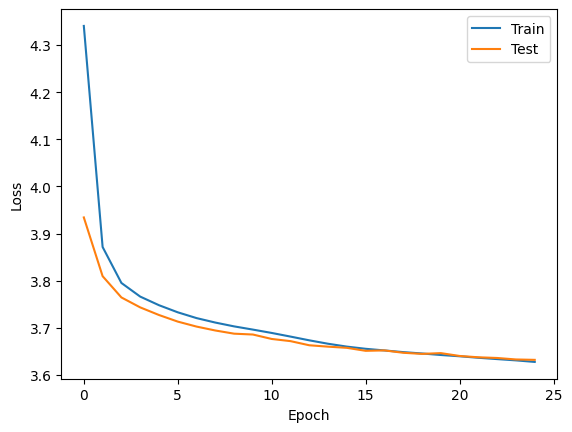

In [12]:
plt.plot(train_losses, label = 'Train')
plt.plot(test_losses, label = 'Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Testing and comparing to old model

In [13]:
#read in the old pymc ev dists
pymc_effects = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/bip_distributions/exit_speed/ev_dists_sloan_version_testing.csv')
train = train.merge(pymc_effects[['batter_id_hand', 'batter_a_gb', 'batter_a_ld', 'batter_a_fb', 'batter_a_pu', 'batter_s_gb', 'batter_s_ld', 'batter_s_fb', 'batter_s_pu']], right_on = 'batter_id_hand', left_on = 'batter_id_hand_bool')
test =test.merge(pymc_effects[['batter_id_hand', 'batter_a_gb', 'batter_a_ld', 'batter_a_fb', 'batter_a_pu', 'batter_s_gb', 'batter_s_ld', 'batter_s_fb', 'batter_s_pu']], right_on = 'batter_id_hand', left_on = 'batter_id_hand_bool')

In [14]:
#pymc log likes
train['old_alpha'] = train.is_gb.values * train.batter_a_gb.values + train.is_ld.values * train.batter_a_ld.values + train.is_pu.values * train.batter_a_pu.values + train.is_fb.values * train.batter_a_fb.values
train['old_scale'] = train.is_gb.values * train.batter_s_gb.values + train.is_ld.values * train.batter_s_ld.values + train.is_pu.values * train.batter_s_pu.values + train.is_fb.values * train.batter_s_fb.values
test['old_alpha'] = test.is_gb.values * test.batter_a_gb.values + test.is_ld.values * test.batter_a_ld.values + test.is_pu.values * test.batter_a_pu.values + test.is_fb.values * test.batter_a_fb.values
test['old_scale'] = test.is_gb.values * test.batter_s_gb.values + test.is_ld.values * test.batter_s_ld.values + test.is_pu.values * test.batter_s_pu.values + test.is_fb.values * test.batter_s_fb.values
train['old_log_like'] = gamma(a = train.old_alpha.values, scale = train.old_scale.values).logpdf(train.ev2.values)
test['old_log_like'] = gamma(a = test.old_alpha.values , scale = test.old_scale.values).logpdf(test.ev2.values)

In [15]:
#calculate nnet log likes
alpha, beta = model(torch.tensor(train[features].values, dtype = torch.float32).to(device))
train['alpha'] = alpha.detach().cpu().numpy()
train['beta'] = beta.detach().cpu().numpy()
alpha, beta = model(torch.tensor(test[features].values, dtype = torch.float32).to(device))
test['alpha'] = alpha.detach().cpu().numpy()
test['beta'] = beta.detach().cpu().numpy()
train['log_like'] = gamma(a = train.alpha.values, scale = 1/train.beta.values).logpdf(train.ev2.values)
test['log_like'] = gamma(a = test.alpha.values, scale = 1/test.beta.values).logpdf(test.ev2.values)

In [16]:
#compare log likelihood on train set
train.old_log_like.mean(), train.log_like.mean()

(np.float64(-3.9154723917431435), np.float64(-3.6255766575067425))

In [17]:
#test set comp
test.old_log_like.mean(), test.log_like.mean()

(np.float64(-3.944604106048962), np.float64(-3.6317469165343894))

Log likelihood is better for the neural net in both the train and test set.

In [18]:
#draw samples for each launch angle in the datasets using the neural nets
train['samples'] = all_data.launch_speed.max() + 0.1 - gamma(a = train.alpha.values, scale = 1/train.beta.values).rvs()
test['samples'] = all_data.launch_speed.max() + 0.1 - gamma(a = test.alpha.values, scale = 1/test.beta.values).rvs()
#now with the pymc dists
train['old_samples'] = all_data.launch_speed.max() + 0.1 - gamma(a = train.old_alpha.values, scale = train.old_scale.values).rvs()
test['old_samples'] = all_data.launch_speed.max() + 0.1 - gamma(a = test.old_alpha.values, scale = test.old_scale.values).rvs()

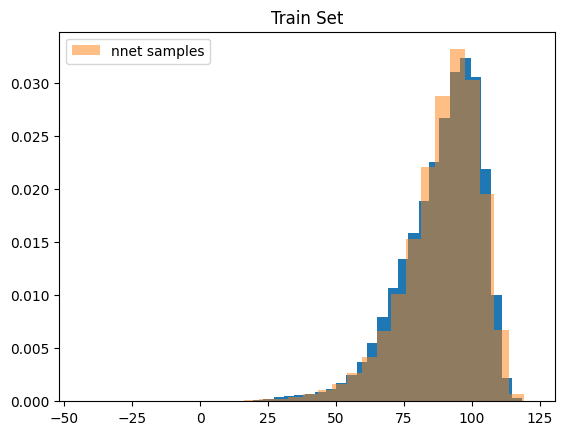

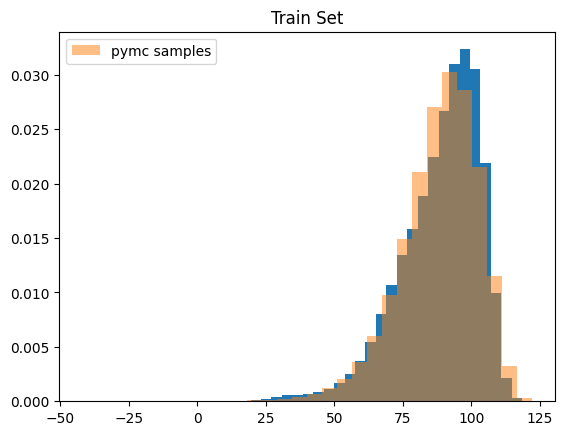

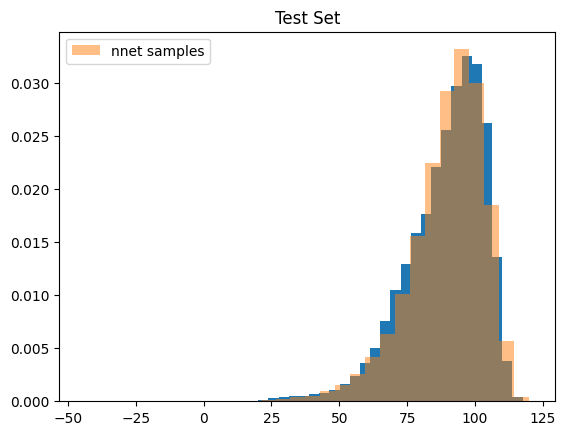

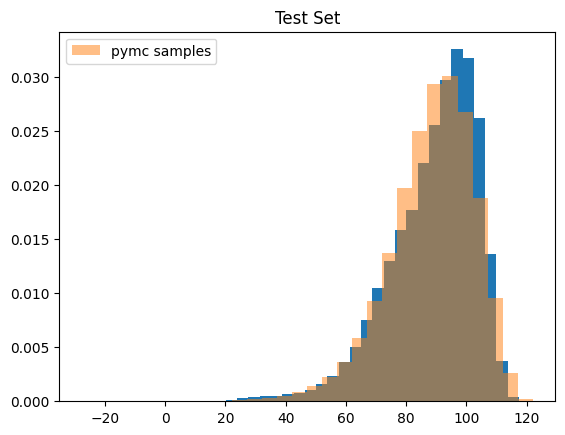

In [19]:
#compare the samples with the actual launch speeds
plt.hist(train.launch_speed.values, density = True, bins = 30)
plt.hist(train.samples.values, density = True, bins = 30, alpha = 0.5, label = 'nnet samples')
plt.legend()
plt.title('Train Set')
plt.show()

plt.hist(train.launch_speed.values, density = True, bins = 30)
plt.hist(train.old_samples.values, density = True, bins = 30, alpha = 0.5, label = 'pymc samples')
plt.legend()
plt.title('Train Set')
plt.show()

plt.hist(test.launch_speed.values, density = True, bins = 30)
plt.hist(test.samples.values, density = True, bins = 30, alpha = 0.5, label = 'nnet samples')
plt.legend()
plt.title('Test Set')
plt.show()

plt.hist(test.launch_speed.values, density = True, bins = 30)
plt.hist(test.old_samples.values, density = True, bins = 30, alpha = 0.5, label = 'pymc samples')
plt.legend()
plt.title('Test Set')
plt.show()

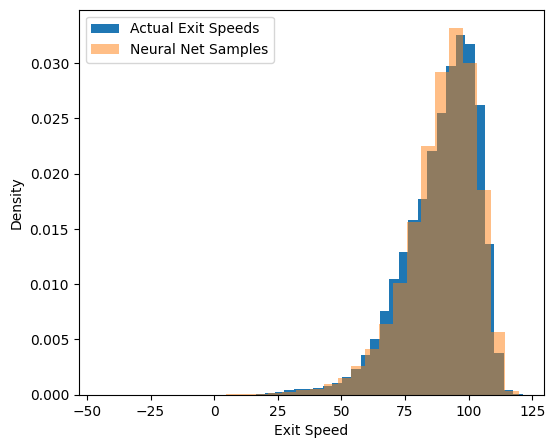

In [20]:
#for paper
plt.figure(figsize = (6,5))
plt.hist(test.launch_speed.values, density = True, bins = 30, label = 'Actual Exit Speeds')
plt.hist(test.samples.values, density = True, bins = 30, alpha = 0.5, label = 'Neural Net Samples')
plt.legend()
plt.ylabel('Density')
plt.xlabel('Exit Speed')
plt.show()

I think the neural net samples look slightly better here.

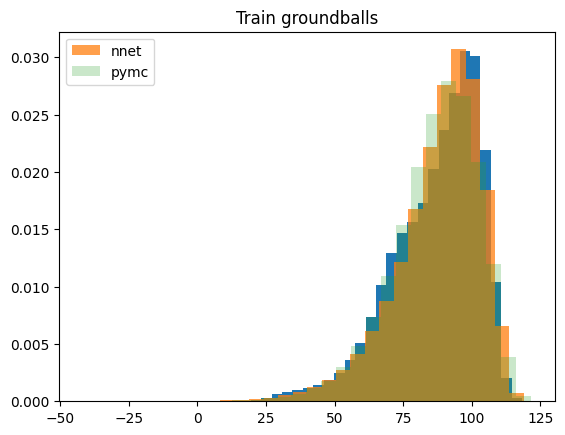

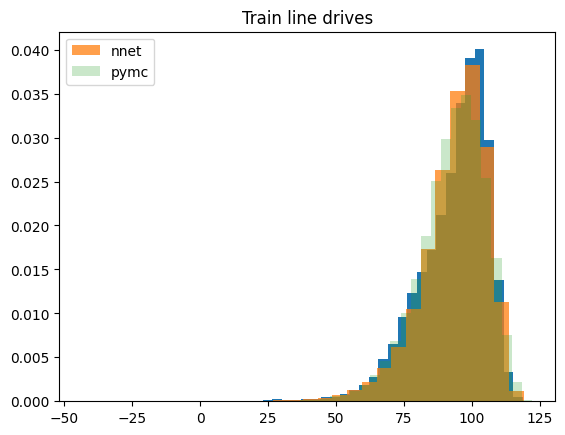

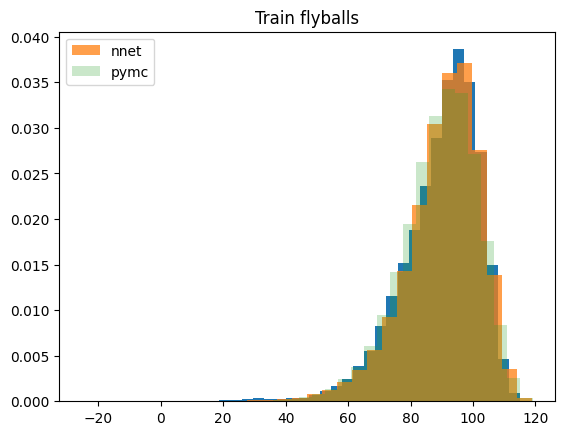

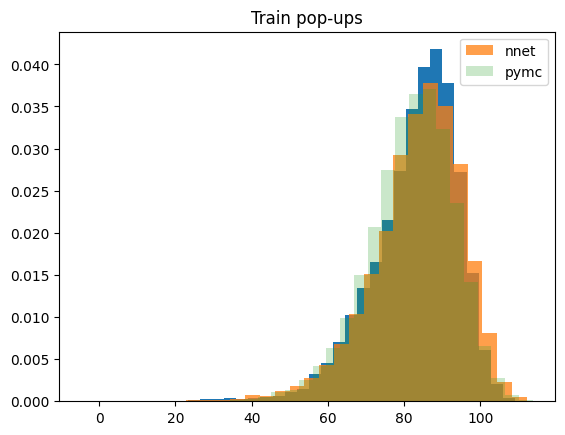

In [21]:
#break down by la type
plt.hist(train.loc[train.is_gb == 1].launch_speed.values, density = True, bins = 30)
plt.hist(train.loc[train.is_gb == 1].samples.values, density = True, bins = 30, alpha = 0.75, label = 'nnet')
plt.hist(train.loc[train.is_gb == 1].old_samples.values, density = True, bins = 30, alpha = 0.25, label = 'pymc')
plt.title('Train groundballs')
plt.legend()
plt.show()

plt.hist(train.loc[train.is_ld == 1].launch_speed.values, density = True, bins = 30)
plt.hist(train.loc[train.is_ld == 1].samples.values, density = True, bins = 30, alpha = 0.75, label = 'nnet')
plt.hist(train.loc[train.is_ld == 1].old_samples.values, density = True, bins = 30, alpha = 0.25, label = 'pymc')
plt.title('Train line drives')
plt.legend()
plt.show()

plt.hist(train.loc[train.is_fb == 1].launch_speed.values, density = True, bins = 30)
plt.hist(train.loc[train.is_fb == 1].samples.values, density = True, bins = 30, alpha = 0.75, label = 'nnet')
plt.hist(train.loc[train.is_fb == 1].old_samples.values, density = True, bins = 30, alpha = 0.25, label = 'pymc')
plt.title('Train flyballs')
plt.legend()
plt.show()

plt.hist(train.loc[train.is_pu == 1].launch_speed.values, density = True, bins = 30)
plt.hist(train.loc[train.is_pu == 1].samples.values, density = True, bins = 30, alpha = 0.75, label = 'nnet')
plt.hist(train.loc[train.is_pu == 1].old_samples.values, density = True, bins = 30, alpha = 0.25, label = 'pymc')
plt.title('Train pop-ups')
plt.legend()
plt.show()

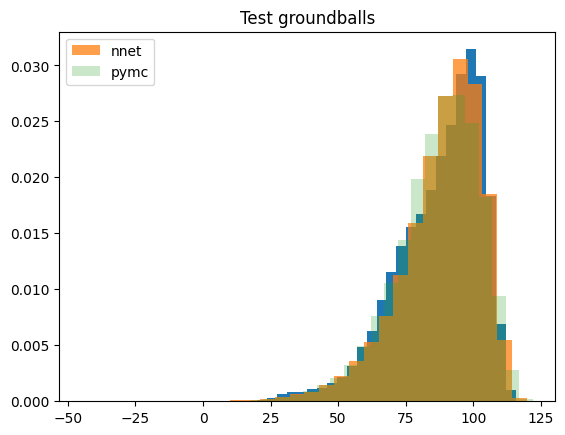

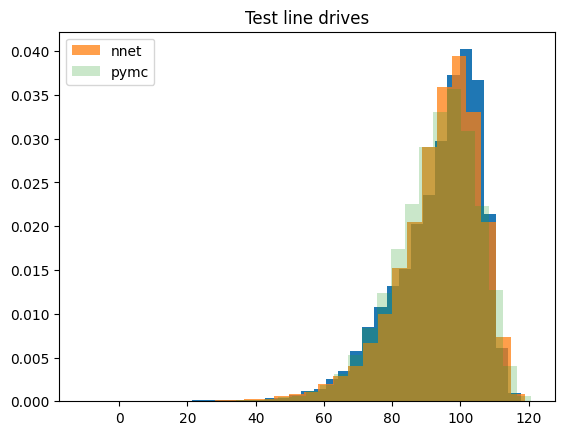

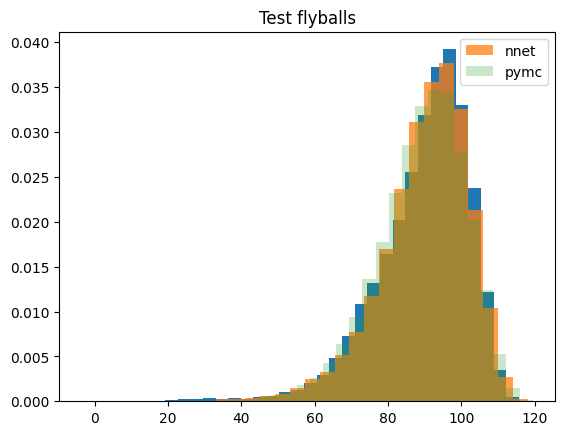

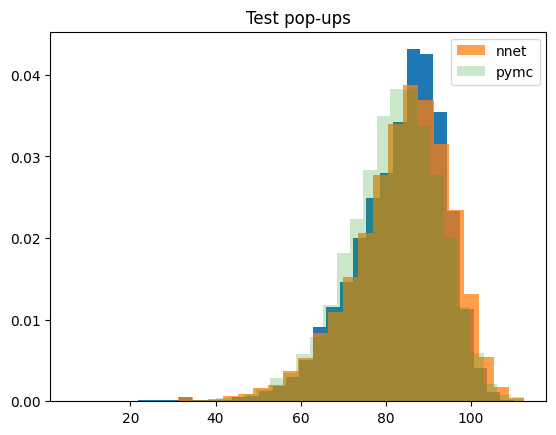

In [22]:
#break down by la type
plt.hist(test.loc[test.is_gb == 1].launch_speed.values, density = True, bins = 30)
plt.hist(test.loc[test.is_gb == 1].samples.values, density = True, bins = 30, alpha = 0.75, label = 'nnet')
plt.hist(test.loc[test.is_gb == 1].old_samples.values, density = True, bins = 30, alpha = 0.25, label = 'pymc')
plt.title('Test groundballs')
plt.legend()
plt.show()

plt.hist(test.loc[test.is_ld == 1].launch_speed.values, density = True, bins = 30)
plt.hist(test.loc[test.is_ld == 1].samples.values, density = True, bins = 30, alpha = 0.75, label = 'nnet')
plt.hist(test.loc[test.is_ld == 1].old_samples.values, density = True, bins = 30, alpha = 0.25, label = 'pymc')
plt.title('Test line drives')
plt.legend()
plt.show()

plt.hist(test.loc[test.is_fb == 1].launch_speed.values, density = True, bins = 30)
plt.hist(test.loc[test.is_fb == 1].samples.values, density = True, bins = 30, alpha = 0.75, label = 'nnet')
plt.hist(test.loc[test.is_fb == 1].old_samples.values, density = True, bins = 30, alpha = 0.25, label = 'pymc')
plt.title('Test flyballs')
plt.legend()
plt.show()

plt.hist(test.loc[test.is_pu == 1].launch_speed.values, density = True, bins = 30)
plt.hist(test.loc[test.is_pu == 1].samples.values, density = True, bins = 30, alpha = 0.75, label = 'nnet')
plt.hist(test.loc[test.is_pu == 1].old_samples.values, density = True, bins = 30, alpha = 0.25, label = 'pymc')
plt.title('Test pop-ups')
plt.legend()
plt.show()

Those all look fine.

In [23]:
#individual hitters
#combine test and train so we have plenty of data for each individual
df = pd.concat((train, test))

#lowe
hitter = df.loc[df.batter == 663993]

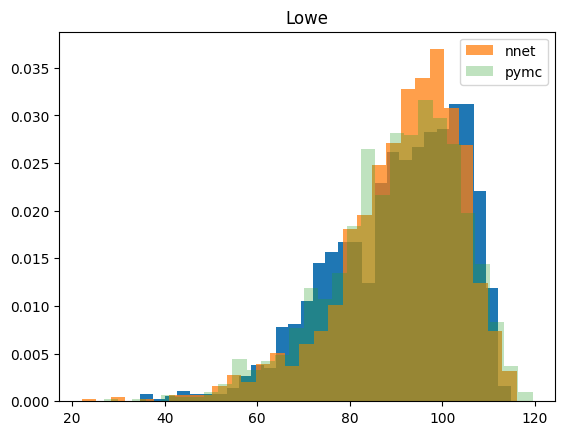

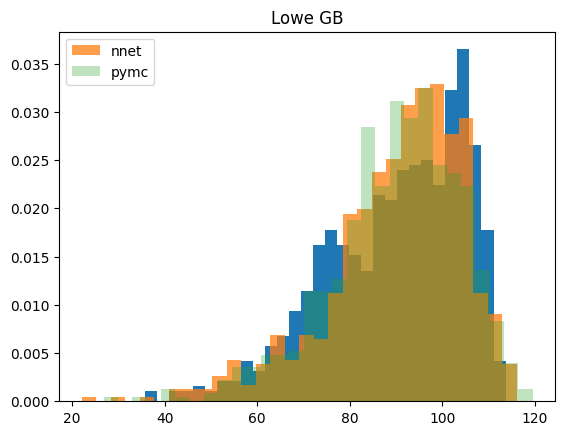

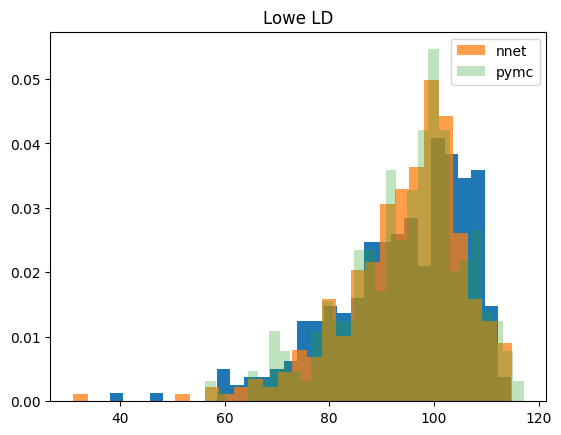

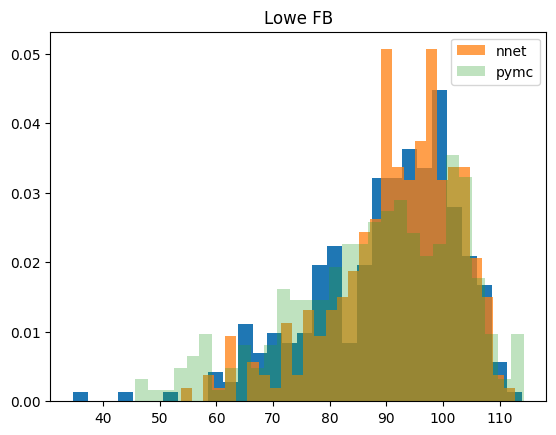

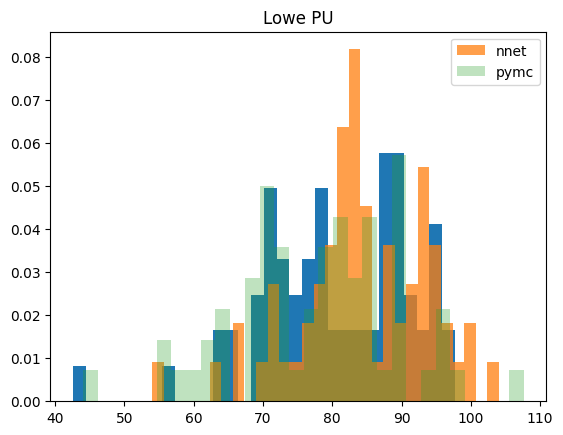

In [24]:
plt.hist(hitter.launch_speed.values, density = True, bins = 30)
plt.hist(hitter.samples.values, density = True, bins = 30, alpha = 0.75, label = 'nnet')
plt.hist(hitter.old_samples.values, density = True, bins = 30, alpha = 0.3, label = 'pymc')
plt.title('Lowe')
plt.legend()
plt.show()

plt.hist(hitter.loc[hitter.is_gb == 1].launch_speed.values, density = True, bins = 30)
plt.hist(hitter.loc[hitter.is_gb == 1].samples.values, density = True, bins = 30, alpha = 0.75, label = 'nnet')
plt.hist(hitter.loc[hitter.is_gb == 1].old_samples.values, density = True, bins = 30, alpha = 0.3, label = 'pymc')
plt.title('Lowe GB')
plt.legend()
plt.show()

plt.hist(hitter.loc[hitter.is_ld == 1].launch_speed.values, density = True, bins = 30)
plt.hist(hitter.loc[hitter.is_ld == 1].samples.values, density = True, bins = 30, alpha = 0.75, label = 'nnet')
plt.hist(hitter.loc[hitter.is_ld == 1].old_samples.values, density = True, bins = 30, alpha = 0.3, label = 'pymc')
plt.title('Lowe LD')
plt.legend()
plt.show()

plt.hist(hitter.loc[hitter.is_fb == 1].launch_speed.values, density = True, bins = 30)
plt.hist(hitter.loc[hitter.is_fb == 1].samples.values, density = True, bins = 30, alpha = 0.75, label = 'nnet')
plt.hist(hitter.loc[hitter.is_fb == 1].old_samples.values, density = True, bins = 30, alpha = 0.3, label = 'pymc')
plt.title('Lowe FB')
plt.legend()
plt.show()

plt.hist(hitter.loc[hitter.is_pu == 1].launch_speed.values, density = True, bins = 30)
plt.hist(hitter.loc[hitter.is_pu == 1].samples.values, density = True, bins = 30, alpha = 0.75, label = 'nnet')
plt.hist(hitter.loc[hitter.is_pu == 1].old_samples.values, density = True, bins = 30, alpha = 0.3, label = 'pymc')
plt.title('Lowe PU')
plt.legend()
plt.show()

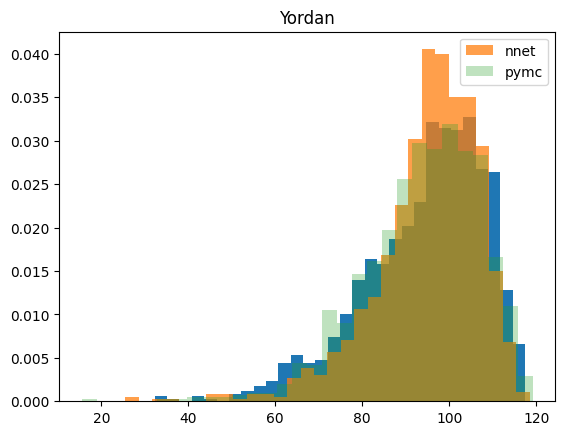

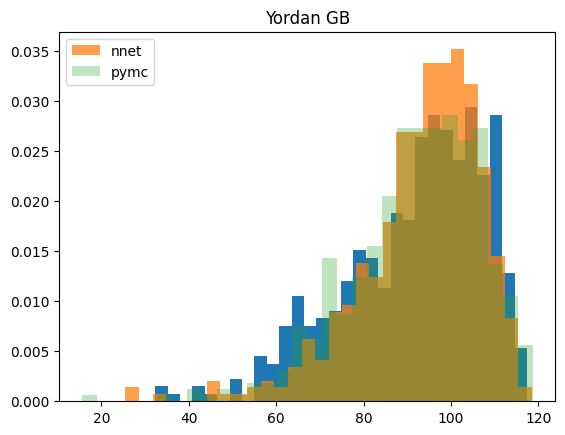

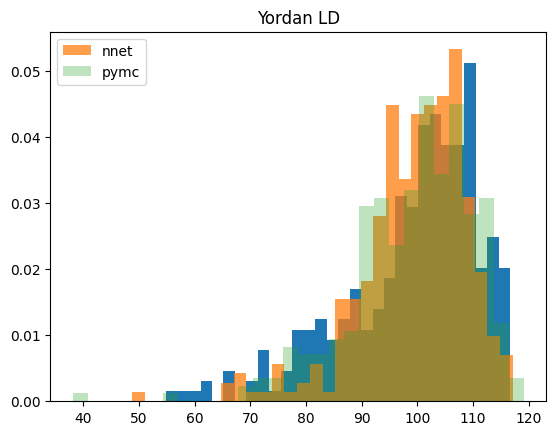

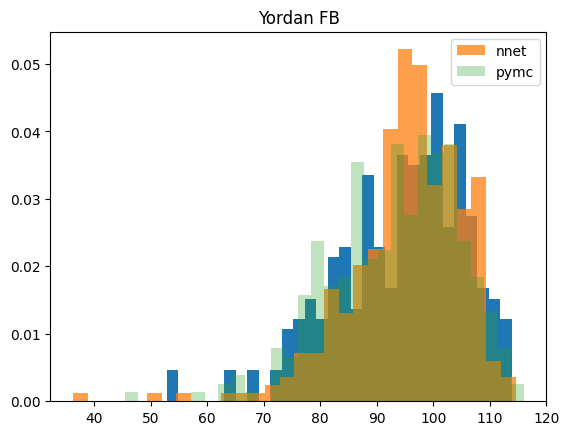

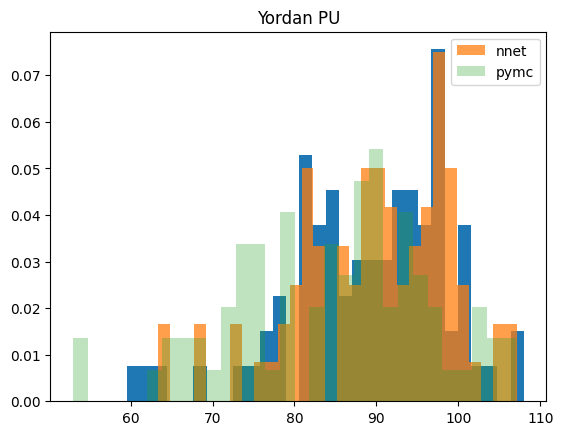

In [25]:
#hard hitting yordan
hitter2 = df.loc[df.batter == 670541]
plt.hist(hitter2.launch_speed.values, density = True, bins = 30)
plt.hist(hitter2.samples.values, density = True, bins = 30, alpha = 0.75, label = 'nnet')
plt.hist(hitter2.old_samples.values, density = True, bins = 30, alpha = 0.3, label = 'pymc')
plt.title('Yordan')
plt.legend()
plt.show()

plt.hist(hitter2.loc[hitter2.is_gb == 1].launch_speed.values, density = True, bins = 30)
plt.hist(hitter2.loc[hitter2.is_gb == 1].samples.values, density = True, bins = 30, alpha = 0.75, label = 'nnet')
plt.hist(hitter2.loc[hitter2.is_gb == 1].old_samples.values, density = True, bins = 30, alpha = 0.3, label = 'pymc')
plt.title('Yordan GB')
plt.legend()
plt.show()

plt.hist(hitter2.loc[hitter2.is_ld == 1].launch_speed.values, density = True, bins = 30)
plt.hist(hitter2.loc[hitter2.is_ld == 1].samples.values, density = True, bins = 30, alpha = 0.75, label = 'nnet')
plt.hist(hitter2.loc[hitter2.is_ld == 1].old_samples.values, density = True, bins = 30, alpha = 0.3, label = 'pymc')
plt.title('Yordan LD')
plt.legend()
plt.show()

plt.hist(hitter2.loc[hitter2.is_fb == 1].launch_speed.values, density = True, bins = 30)
plt.hist(hitter2.loc[hitter2.is_fb == 1].samples.values, density = True, bins = 30, alpha = 0.75, label = 'nnet')
plt.hist(hitter2.loc[hitter2.is_fb == 1].old_samples.values, density = True, bins = 30, alpha = 0.3, label = 'pymc')
plt.title('Yordan FB')
plt.legend()
plt.show()

plt.hist(hitter2.loc[hitter2.is_pu == 1].launch_speed.values, density = True, bins = 30)
plt.hist(hitter2.loc[hitter2.is_pu == 1].samples.values, density = True, bins = 30, alpha = 0.75, label = 'nnet')
plt.hist(hitter2.loc[hitter2.is_pu == 1].old_samples.values, density = True, bins = 30, alpha = 0.3, label = 'pymc')
plt.title('Yordan PU')
plt.legend()
plt.show()

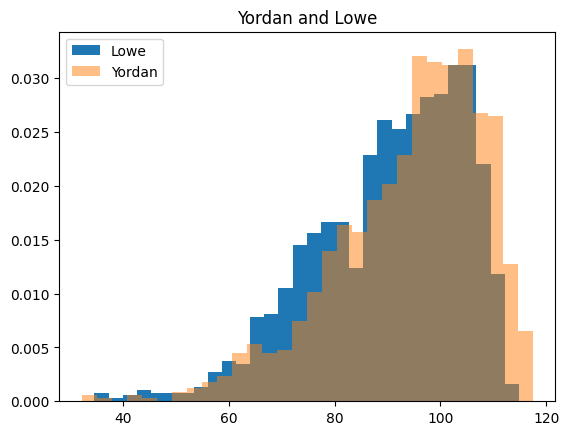

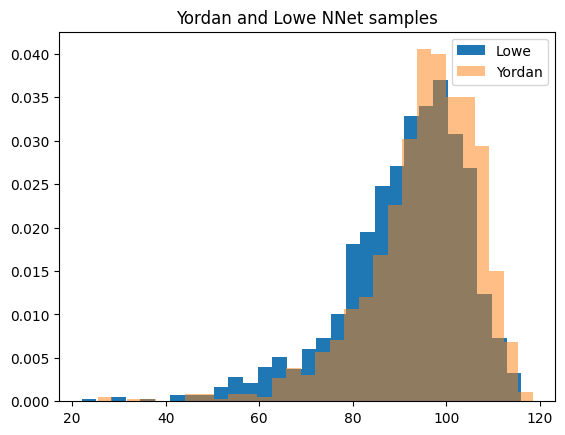

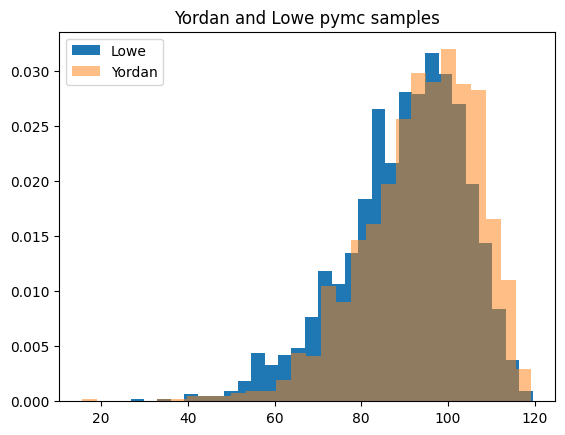

In [26]:
#compare yordan and Lowe
plt.hist(hitter.launch_speed.values, density = True, bins = 30, label = 'Lowe')
plt.hist(hitter2.launch_speed.values, density = True, bins = 30, label = 'Yordan', alpha = 0.5)
plt.legend()
plt.title('Yordan and Lowe')
plt.show()

plt.hist(hitter.samples.values, density = True, bins = 30, label = 'Lowe')
plt.hist(hitter2.samples.values, density = True, bins = 30, label = 'Yordan', alpha = 0.5)
plt.legend()
plt.title('Yordan and Lowe NNet samples')
plt.show()

plt.hist(hitter.old_samples.values, density = True, bins = 30, label = 'Lowe')
plt.hist(hitter2.old_samples.values, density = True, bins = 30, label = 'Yordan', alpha = 0.5)
plt.legend()
plt.title('Yordan and Lowe pymc samples')
plt.show()

Lowe is a harder hitter than I thought. I want a weak hitter. Let's try nicky lopez

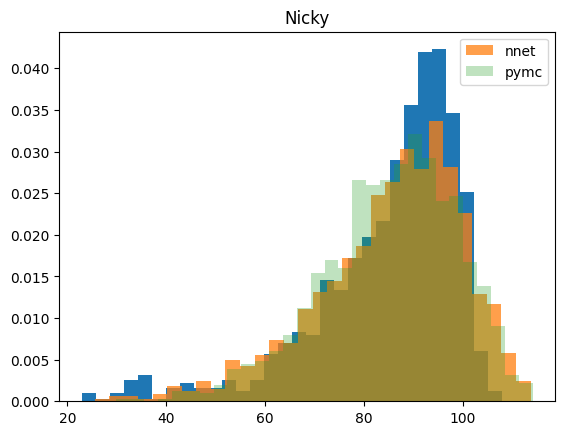

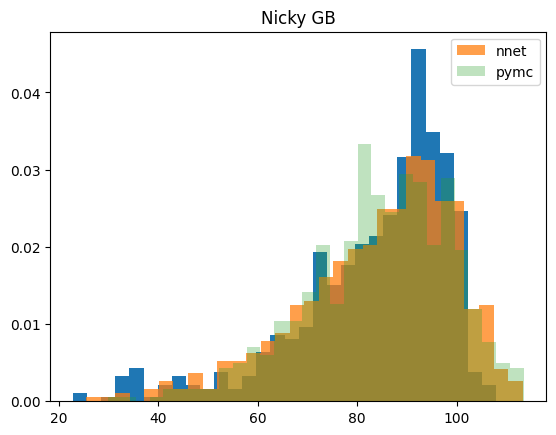

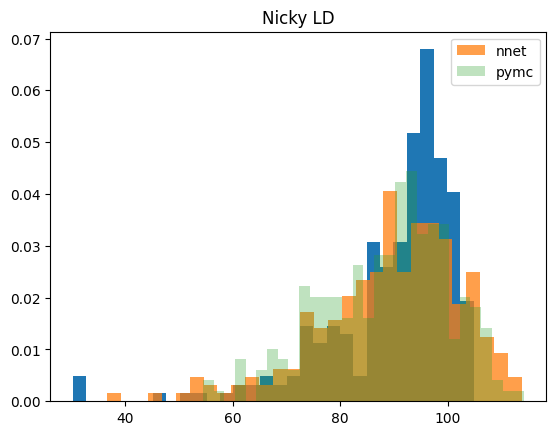

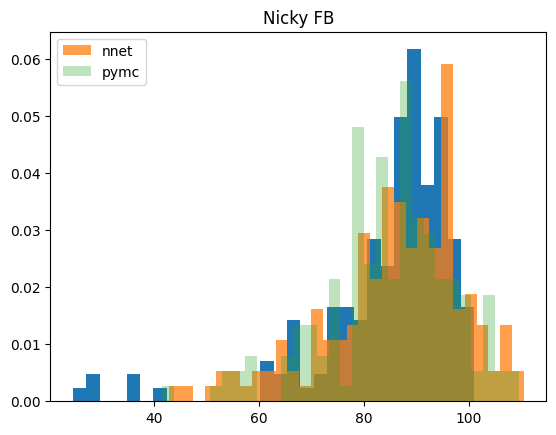

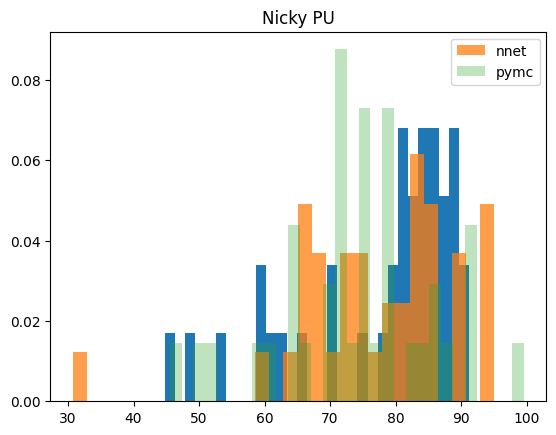

In [27]:
#nicky lopez (taylor swift)
hitter = df.loc[df.batter == 670032]
plt.hist(hitter.launch_speed.values, density = True, bins = 30)
plt.hist(hitter.samples.values, density = True, bins = 30, alpha = 0.75, label = 'nnet')
plt.hist(hitter.old_samples.values, density = True, bins = 30, alpha = 0.3, label = 'pymc')
plt.title('Nicky')
plt.legend()
plt.show()

plt.hist(hitter.loc[hitter.is_gb == 1].launch_speed.values, density = True, bins = 30)
plt.hist(hitter.loc[hitter.is_gb == 1].samples.values, density = True, bins = 30, alpha = 0.75, label = 'nnet')
plt.hist(hitter.loc[hitter.is_gb == 1].old_samples.values, density = True, bins = 30, alpha = 0.3, label = 'pymc')
plt.title('Nicky GB')
plt.legend()
plt.show()

plt.hist(hitter.loc[hitter.is_ld == 1].launch_speed.values, density = True, bins = 30)
plt.hist(hitter.loc[hitter.is_ld == 1].samples.values, density = True, bins = 30, alpha = 0.75, label = 'nnet')
plt.hist(hitter.loc[hitter.is_ld == 1].old_samples.values, density = True, bins = 30, alpha = 0.3, label = 'pymc')
plt.title('Nicky LD')
plt.legend()
plt.show()

plt.hist(hitter.loc[hitter.is_fb == 1].launch_speed.values, density = True, bins = 30)
plt.hist(hitter.loc[hitter.is_fb == 1].samples.values, density = True, bins = 30, alpha = 0.75, label = 'nnet')
plt.hist(hitter.loc[hitter.is_fb == 1].old_samples.values, density = True, bins = 30, alpha = 0.3, label = 'pymc')
plt.title('Nicky FB')
plt.legend()
plt.show()

plt.hist(hitter.loc[hitter.is_pu == 1].launch_speed.values, density = True, bins = 30)
plt.hist(hitter.loc[hitter.is_pu == 1].samples.values, density = True, bins = 30, alpha = 0.75, label = 'nnet')
plt.hist(hitter.loc[hitter.is_pu == 1].old_samples.values, density = True, bins = 30, alpha = 0.3, label = 'pymc')
plt.title('Nicky PU')
plt.legend()
plt.show()

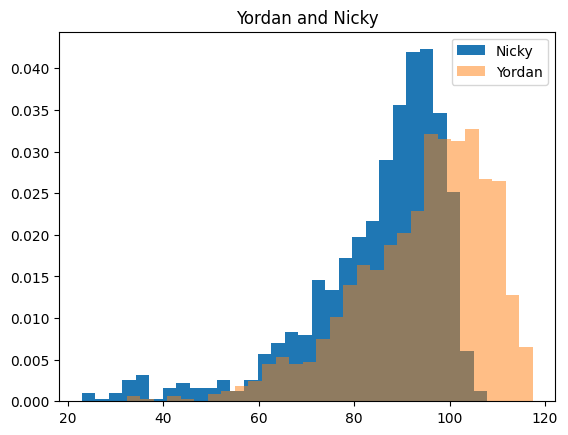

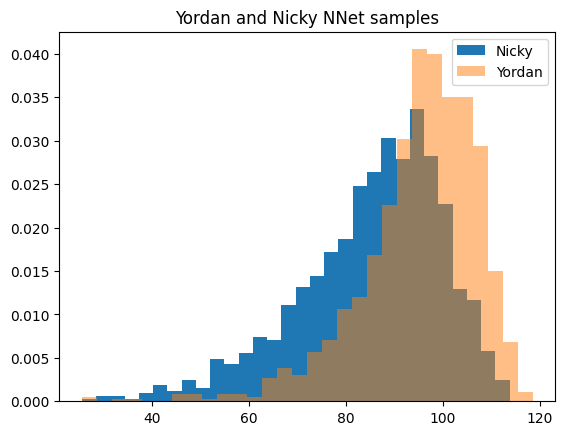

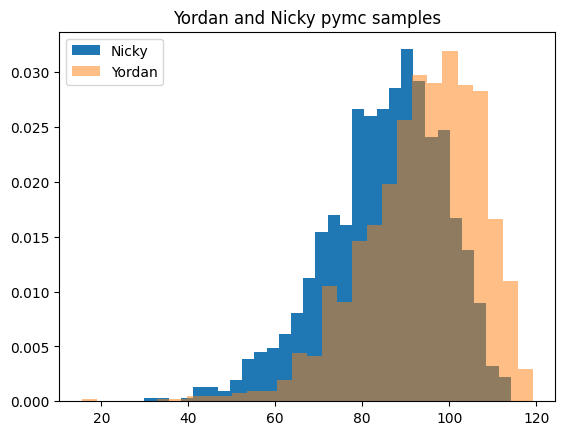

In [28]:
#compare yordan and Lopez
plt.hist(hitter.launch_speed.values, density = True, bins = 30, label = 'Nicky')
plt.hist(hitter2.launch_speed.values, density = True, bins = 30, label = 'Yordan', alpha = 0.5)
plt.legend()
plt.title('Yordan and Nicky')
plt.show()

plt.hist(hitter.samples.values, density = True, bins = 30, label = 'Nicky')
plt.hist(hitter2.samples.values, density = True, bins = 30, label = 'Yordan', alpha = 0.5)
plt.legend()
plt.title('Yordan and Nicky NNet samples')
plt.show()

plt.hist(hitter.old_samples.values, density = True, bins = 30, label = 'Nicky')
plt.hist(hitter2.old_samples.values, density = True, bins = 30, label = 'Yordan', alpha = 0.5)
plt.legend()
plt.title('Yordan and Nicky pymc samples')
plt.show()

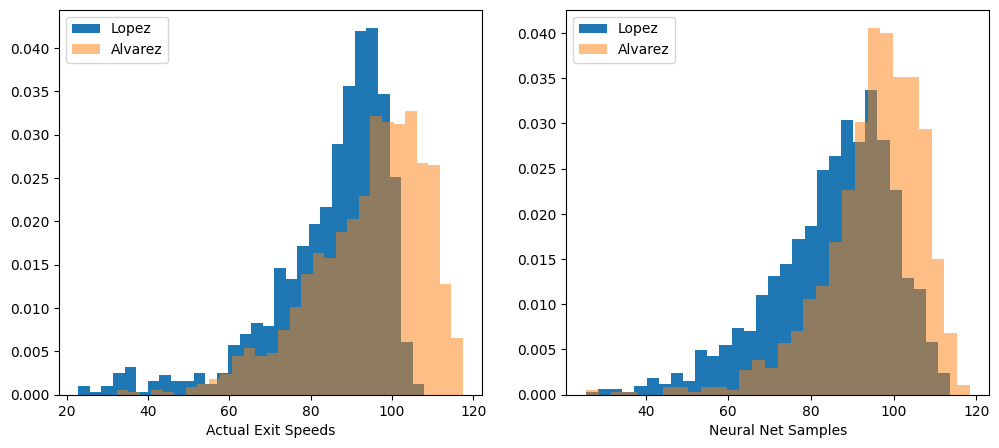

In [31]:
#compare yordan and Lopez
plt.figure(figsize = ((12,5)))
ax1 = plt.subplot(121)
ax1.hist(hitter.launch_speed.values, density = True, bins = 30, label = 'Lopez')
ax1.hist(hitter2.launch_speed.values, density = True, bins = 30, label = 'Alvarez', alpha = 0.5)
ax1.legend()
ax1.set_xlabel('Actual Exit Speeds')

ax2 = plt.subplot(122)
ax2.hist(hitter.samples.values, density = True, bins = 30, label = 'Lopez')
ax2.hist(hitter2.samples.values, density = True, bins = 30, label = 'Alvarez', alpha = 0.5)
ax2.legend()
ax2.set_xlabel('Neural Net Samples')
plt.show()